In [22]:
import pandas as pd
import matplotlib.pyplot as plt
from pandas.tseries.offsets import MonthEnd

In [23]:
# ----------------------------
# 1. Load and Clean Data
# ----------------------------

futures_filepath = '/Users/markbogorad/Desktop/NYU_MFE/Semester_2/1.2_Trading_Energy_Derivatives_MATH_GA_2800/Oil_Project/Systematic_Energy_Trading/Data/rolling_test.xlsx'

def load_futures_data(futures_filepath):
    df = pd.read_excel(futures_filepath, sheet_name='WTI')
    df['Date'] = pd.to_datetime(df['Date'])
    df['WTI_F_1'] = df['WTI F_1'].replace('[\\$,]', '', regex=True).astype(float)
    df['WTI_F_2'] = df['WTI F_2'].replace('[\\$,]', '', regex=True).astype(float)
    return df

futures_df = load_futures_data(futures_filepath)


In [24]:
# ----------------------------
# 2. Define EOM Roll Calendar (No Expiry)
# ----------------------------

def define_eom_roll_calendar(df):
    # Mark roll days as the last business day of each month
    df['Roll'] = 0
    df.loc[df['Date'] == df['Date'] + MonthEnd(0), 'Roll'] = 1
    
    # Define actions based on roll
    df['Action'] = 'Hold'
    df.loc[df.index[0], 'Action'] = 'Buy'                    # Initial buy
    df.loc[df['Roll'] == 1, 'Action'] = 'Sell & Buy'         # Roll day
    df.loc[df.index[-1], 'Action'] = 'Sell'                  # Final sell

    return df

futures_df = define_eom_roll_calendar(futures_df)



In [25]:

def calculate_eom_rolling_futures(df, transaction_cost=0.01):
    rolling_futures = []
    rolling_pnl = []
    cumulative_costs = []
    total_cost = 0

    for idx in range(len(df)):
        t_cost = 0

        # First Day - Buy F1
        if idx == 0:
            t_cost = transaction_cost
            total_cost += t_cost
            rolling_futures.append(df.loc[idx, 'WTI_F_1'] - t_cost)
            rolling_pnl.append(0)

        else:
            # Roll Day: Switch from F1 to F2
            if df.loc[idx, 'Roll'] == 1:
                change = df.loc[idx, 'WTI_F_2'] - df.loc[idx - 1, 'WTI_F_1']
                t_cost = 2 * transaction_cost

            # Normal Day: Always track F1 after roll
            else:
                change = df.loc[idx, 'WTI_F_1'] - df.loc[idx - 1, 'WTI_F_1']

            total_cost += t_cost
            adjusted_value = rolling_futures[-1] + change - t_cost
            rolling_futures.append(adjusted_value)
            rolling_pnl.append(change - t_cost)

        cumulative_costs.append(total_cost)

    # Assign calculated columns to the dataframe
    df['Rolling Futures PnL'] = rolling_pnl
    df['Rolling Futures'] = rolling_futures
    df['Cumulative Transaction Costs'] = cumulative_costs

    return df

futures_df = calculate_eom_rolling_futures(futures_df, transaction_cost=0.01)

In [26]:

# ----------------------------
# 4. Metrics
# ----------------------------

def calculate_metrics(df):
    first_value = df['Rolling Futures'].iloc[0]
    last_value = df['Rolling Futures'].iloc[-1]
    
    pnl = (last_value - first_value) * 100 * 1000
    total_costs = df['Cumulative Transaction Costs'].iloc[-1] * 100 * 1000
    
    metrics = {
        'Rolling Futures PnL': pnl,
        'Total Transaction Costs': total_costs
    }
    
    print("\nWTI Final Figures:")
    for key, value in metrics.items():
        print(f"{key}: ${value:,.2f}")
    
    return metrics

metrics = calculate_metrics(futures_df)



WTI Final Figures:
Rolling Futures PnL: $735,000.00
Total Transaction Costs: $237,000.00


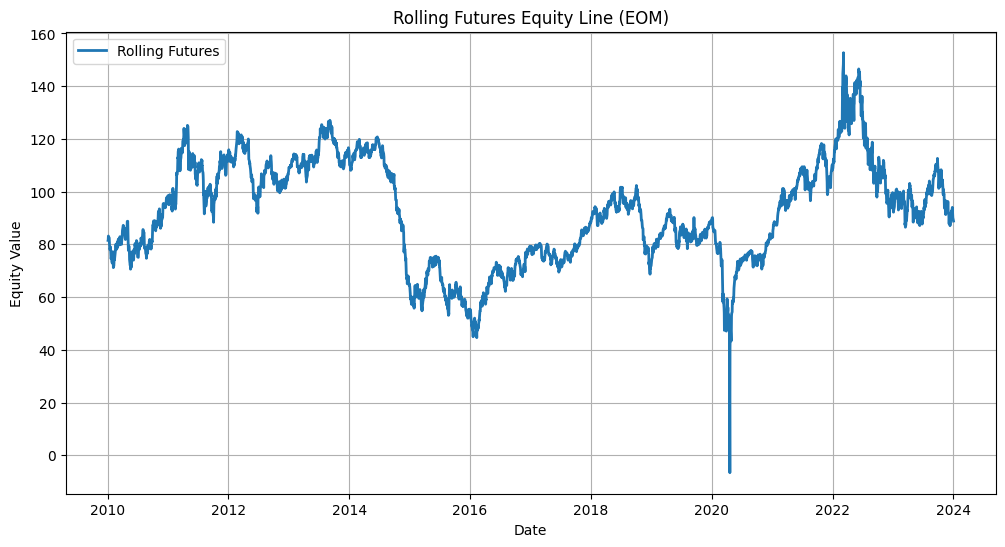

In [27]:
# ----------------------------
# 5. Plot the Rolling Futures Equity Line
# ----------------------------

def plot_rolling_futures(df):
    plt.figure(figsize=(12, 6))
    plt.plot(df['Date'], df['Rolling Futures'], label='Rolling Futures', linewidth=2)
    plt.xlabel('Date')
    plt.ylabel('Equity Value')
    plt.title('Rolling Futures Equity Line (EOM)')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_rolling_futures(futures_df)
